# MLP classifier

In this example we use a Multi-layer Perceptron (MLP) classifier on the MNIST digit dataset.

## Data Preparation

We download the MNIST data using HuggingFace's `datasets` library:

In [1]:
from datasets import load_dataset
import numpy as np


mnist_data = load_dataset("mnist")
data_train, data_test = mnist_data["train"], mnist_data["test"]

X_train = np.stack([np.array(example['image']) for example in data_train])
y_train = np.array([example['label'] for example in data_train])

X_test = np.stack([np.array(example['image']) for example in data_test])
y_test = np.array([example['label'] for example in data_test])

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset mnist downloaded and prepared to /home/runner/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Now we need to apply several transformations to the dataset before splitting it into a test and a test set:
- The images come into 28x28 pixels matrices; we reshape them into a vector;
- The images are arrays of RGB codes between 0 and 255. We normalize them by the maximum value to get a range between 0 and 1;
- We hot-encode category numbers.

In [2]:
import jax
import jax.numpy as jnp


def one_hot_encode(x, k):
    "Create a one-hot encoding of x of size k."
    return jnp.array(x[:, None] == jnp.arange(k), dtype=jnp.float32)


@jax.jit
def prepare_data(X, y, num_categories=10):
    y = one_hot_encode(y, num_categories)

    num_examples = X.shape[0]
    num_pixels = 28 * 28
    X = X.reshape(num_examples, num_pixels)
    X = X / 255.0

    return X, y, num_examples


def batch_data(rng_key, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    while True:
        _, rng_key = jax.random.split(rng_key)
        idx = jax.random.choice(
            key=rng_key, a=jnp.arange(data_size), shape=(batch_size,)
        )
        minibatch = tuple(elem[idx] for elem in data)
        yield minibatch


X_train, y_train, N_train = prepare_data(X_train, y_train)
X_test, y_test, N_test = prepare_data(X_test, y_test)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Multi-layer Perceptron

We will use a very simple Bayesian neural network in this example: A MLP with gaussian priors on the weights.

If we note $X$ the array that represents an image and $y$ the array such that $y_i = 0$  if the image is in category $i$, $y_i=1$ otherwise, the model can be written as:

```{math}
\begin{align*}
  \boldsymbol{p} &= \operatorname{NN}(X)\\
  \boldsymbol{y} &\sim \operatorname{Categorical}(\boldsymbol{p})
\end{align*}
```

In [3]:
import flax.linen as nn
import jax.scipy.stats as stats


class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=500)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return nn.log_softmax(x)

model = NN()


def logprior_fn(params):
    """Compute the value of the log-prior density function."""
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return jnp.sum(stats.norm.logpdf(flat_params))


def loglikelihood_fn(params, data):
    """Categorical log-likelihood"""
    X, y = data
    return jnp.sum(y * model.apply(params, X))


@jax.jit
def compute_accuracy(params, X, y):
    """Compute the accuracy of the model.

    To make predictions we take the number that corresponds to the highest
    probability value, which corresponds to a 1-0 loss.
    
    """
    target_class = jnp.argmax(y, axis=1)
    predicted_class = jnp.argmax(model.apply(params, X), axis=1)
    return jnp.mean(predicted_class == target_class)

## Sample From the Posterior Distribution of the MLP's Weights

Now we need to get initial values for the parameters, and we simply sample from their prior distribution:

We now sample from the model's posteriors using SGLD. We discard the first 1000 samples until the sampler has reached the typical set, and then take 2000 samples. We record the model's accuracy with the current values every 100 steps.

In [4]:
from fastprogress.fastprogress import progress_bar

import blackjax
from blackjax.sgmcmc.gradients import grad_estimator


data_size = len(y_train)
batch_size = 512
step_size = 4.5e-5

num_warmup = (data_size // batch_size) * 20
num_samples = 1000

# Batch the data
rng_key = jax.random.PRNGKey(1)
batches = batch_data(rng_key, (X_train, y_train), batch_size, data_size)

# Set the initial state
state = jax.jit(model.init)(rng_key, jnp.ones(X_train.shape[-1]))

# Build the SGLD kernel with a constant learning rate
grad_fn = grad_estimator(logprior_fn, loglikelihood_fn, data_size)
sgld = blackjax.sgld(grad_fn)

# Sample from the posterior
accuracies = []
steps = []

pb = progress_bar(range(num_warmup))
for step in pb:
    _, rng_key = jax.random.split(rng_key)
    batch = next(batches)
    state = jax.jit(sgld)(rng_key, state, batch, step_size)
    if step % 100 == 0:
        accuracy = compute_accuracy(state, X_test, y_test)
        accuracies.append(accuracy)
        steps.append(step)
        pb.comment = f"| error: {100*(1-accuracy): .1f}"

Let us plot the point-wise accuracy at different points in the sampling process:

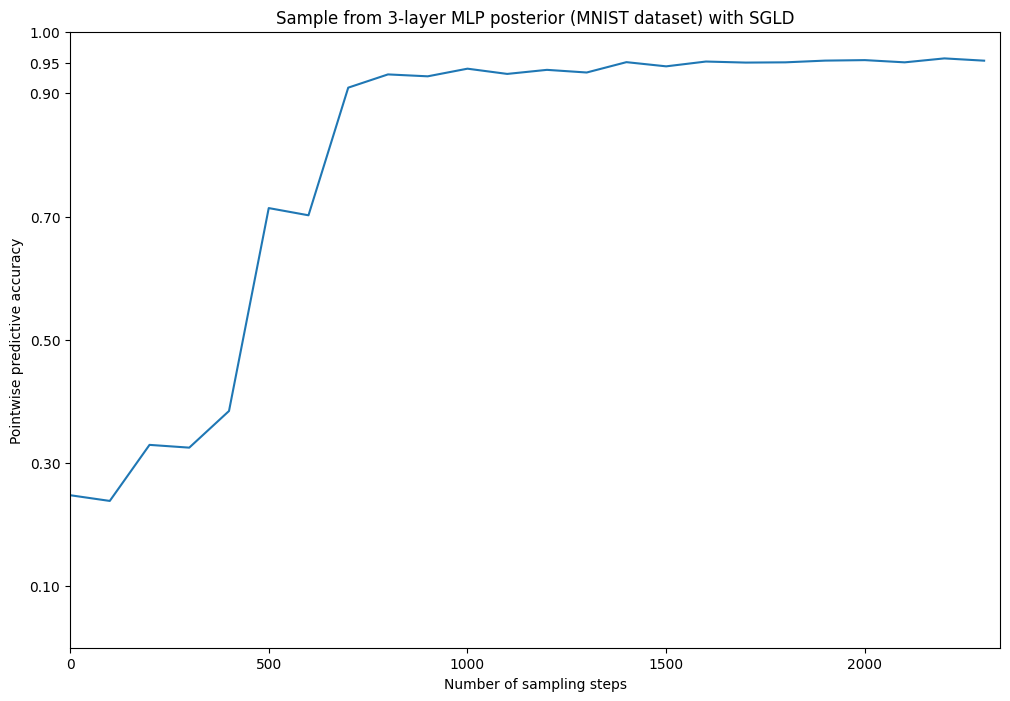

In [5]:
import matplotlib.pylab as plt


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(steps, accuracies)
ax.set_xlabel("Number of sampling steps")
ax.set_ylabel("Pointwise predictive accuracy")
ax.set_xlim([0, num_warmup])
ax.set_ylim([0, 1])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.])
plt.title("Sample from 3-layer MLP posterior (MNIST dataset) with SGLD")
plt.plot();

It looks like the point-wise accuracy, while still increasing, has reached a plateau. We will now sample from the posterior distribution. Instead of accumulating the network weights, which would require a subtantial amounf of memory, we will update the average of the quantity that we are interested in, the predictive probabilities over the test set.

Formally, for each sample $\theta_i$ and each $x_*$ of the test set compute $P(y_*=i\mid x_*, \theta_i)$. We use each sample to update the estimation of $P(y=i \mid x_*)$ with the Monte Carlo approximation:

$$
P(y=i\mid x_*) = \int P(y=i\mid x_*, \theta)P(\theta \mid \mathcal{D})\,\mathrm{d}\theta \approx \frac{1}{N_s} \sum_s P(y=i\mid x_*, \theta_s)
$$

In [6]:
@jax.jit
def update_test_accuracy(i, logpredictprob, sample):
    """Update the running average log-predictive probability
    and return the current value of the accuracy.

    """
    new_logpredictprob = jnp.logaddexp(
        logpredictprob,
        jax.vmap(model.apply, in_axes=(None, 0))(sample, X_test)
    )
    predict_probs = jnp.exp(new_logpredictprob) / (i+1)
    
    predicted = jnp.argmax(predict_probs, axis=1)
    target = jnp.argmax(y_test, axis=1)
    accuracy= jnp.mean(predicted==target)
    
    return new_logpredictprob, accuracy

In [7]:
sgld_accuracies = []
sgld_logpredict = jax.vmap(model.apply, in_axes=(None, 0))(state, X_test)
num_samples = 1000

pb = progress_bar(range(num_samples))
for step in pb:
    _, rng_key = jax.random.split(rng_key)
    batch = next(batches)
    state = jax.jit(sgld)(rng_key, state, batch, step_size)
    sgld_logpredict, accuracy = update_test_accuracy(step, sgld_logpredict, state)
    sgld_accuracies.append(accuracy)
    pb.comment = f"| avg error: {100*(1-accuracy): .1f}"

Let us plot the accuracy as a function of the number of samples:

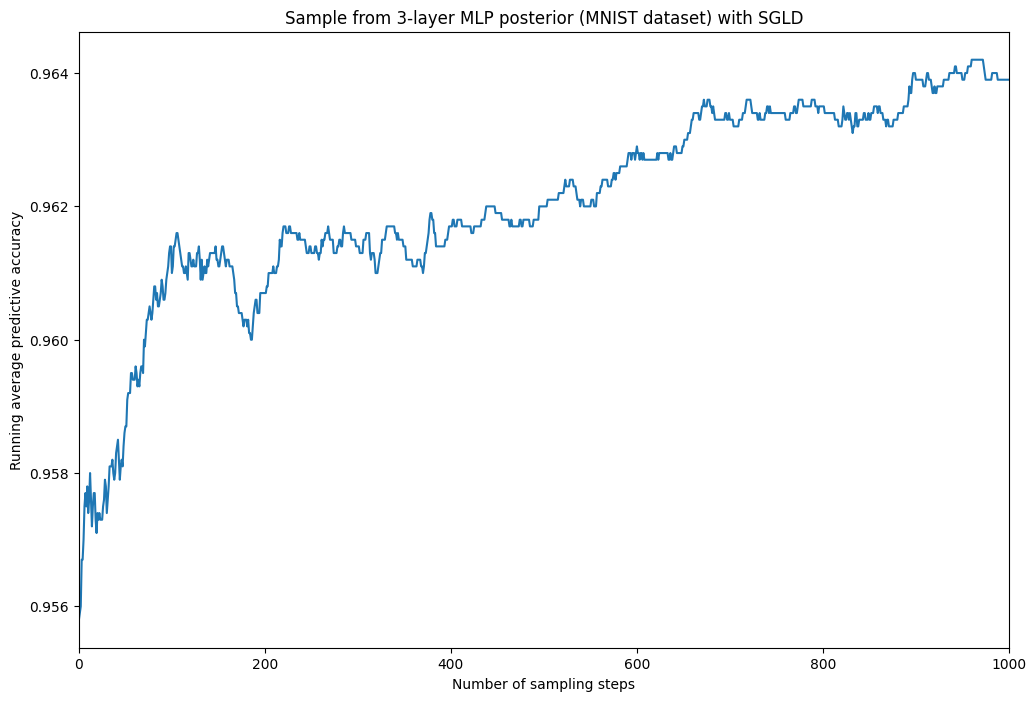

In [8]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(range(num_samples), sgld_accuracies)
ax.set_xlabel("Number of sampling steps")
ax.set_ylabel("Running average predictive accuracy")
ax.set_xlim([0, num_samples])
plt.title("Sample from 3-layer MLP posterior (MNIST dataset) with SGLD")
plt.plot();

It is not clear from the figure above whether the increase of the accuracy is due to an increase in the pointwise accuracy, or an effect of averaging over the posterior distribution. To see this, let us compare the last value to the pointwise accuracy computed on the chain's last state:

In [9]:
last_accuracy = compute_accuracy(state, X_test, y_test)
print(sgld_accuracies[-1], last_accuracy)
print(sgld_accuracies[-1] - last_accuracy)

0.96389997 0.95519996
0.008700013


Averaging the predictive probabilities over the posterior distribution leads to a decrease of 0.8 error point compared to the point-wise accuracy. And in the end, this leads to a decent accuracy for a model that was not fine-tuned (we took the first value of the step size that led to an increasing accuracy).

### Sampling with SGHMC

We can also use SGHMC with a constant learning rate to samples from this model

In [10]:
step_size = 4.5e-6
num_warmup = (data_size // batch_size) * 20

grad_fn = grad_estimator(logprior_fn, loglikelihood_fn, data_size)
sghmc = blackjax.sghmc(grad_fn, num_integration_steps=10)


# Batch the data
state = jax.jit(model.init)(rng_key, jnp.ones(X_train.shape[-1]))

# Sample from the posterior
sghmc_accuracies = []
samples = []
steps = []

pb = progress_bar(range(num_warmup))
for step in pb:
    _, rng_key = jax.random.split(rng_key)
    minibatch = next(batches)
    state = jax.jit(sghmc)(rng_key, state, minibatch, step_size)
    if step % 100 == 0:
        sghmc_accuracy = compute_accuracy(state, X_test, y_test)
        sghmc_accuracies.append(sghmc_accuracy)
        steps.append(step)
        pb.comment = f"| error: {100*(1-sghmc_accuracy): .1f}"

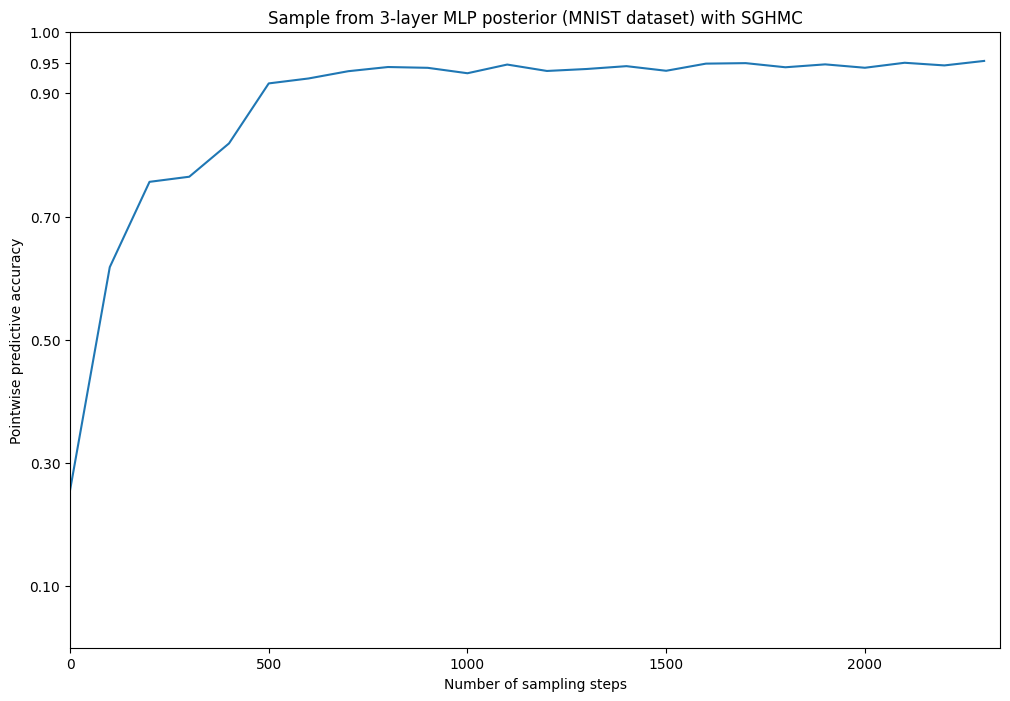

In [11]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(steps, sghmc_accuracies)
ax.set_xlabel("Number of sampling steps")
ax.set_ylabel("Pointwise predictive accuracy")
ax.set_xlim([0, num_warmup])
ax.set_ylim([0, 1])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.])
plt.title("Sample from 3-layer MLP posterior (MNIST dataset) with SGHMC")
plt.plot();

We now sample and compute the accuracy by averaging over the posterior samples:

In [12]:
sghmc_accuracies = []
sghmc_logpredict = jax.vmap(model.apply, in_axes=(None, 0))(state, X_test)

pb = progress_bar(range(num_samples))
for step in pb:
    _, rng_key = jax.random.split(rng_key)
    batch = next(batches)
    state = jax.jit(sgld)(rng_key, state, batch, step_size)
    sghmc_logpredict, accuracy = update_test_accuracy(step, sghmc_logpredict, state)
    sghmc_accuracies.append(accuracy)
    pb.comment = f"| avg error: {100*(1-accuracy): .1f}"

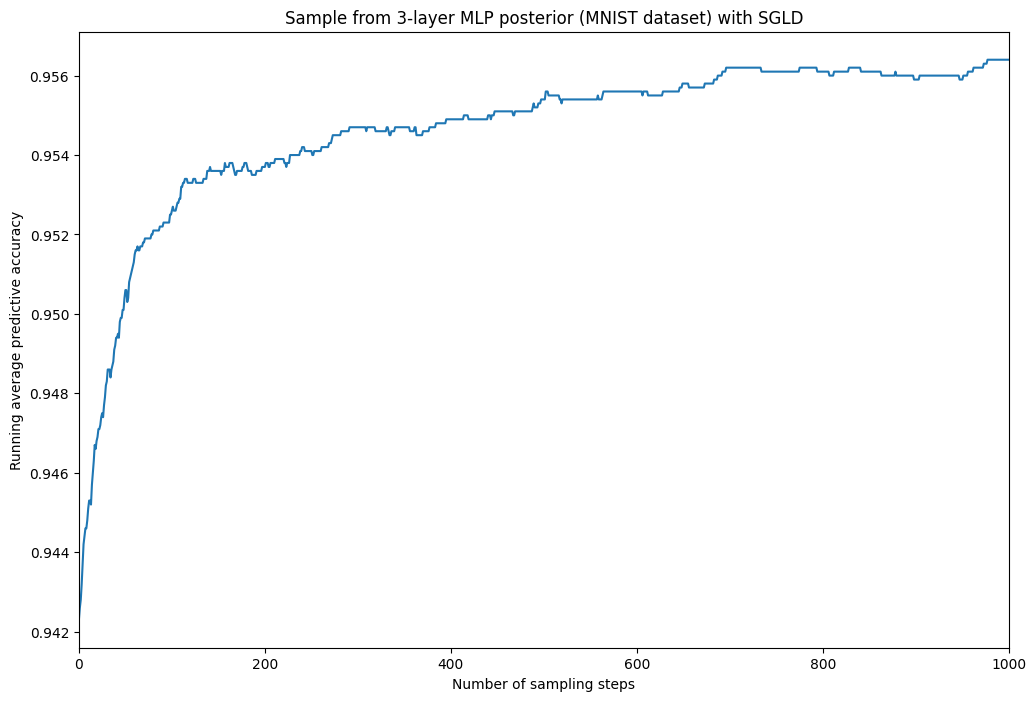

In [13]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(range(num_samples), sghmc_accuracies)
ax.set_xlabel("Number of sampling steps")
ax.set_ylabel("Running average predictive accuracy")
ax.set_xlim([0, num_samples])
plt.title("Sample from 3-layer MLP posterior (MNIST dataset) with SGLD")
plt.plot();

## Comparison

Let us plot the evolution of the accuracy as a function of the number of samples:

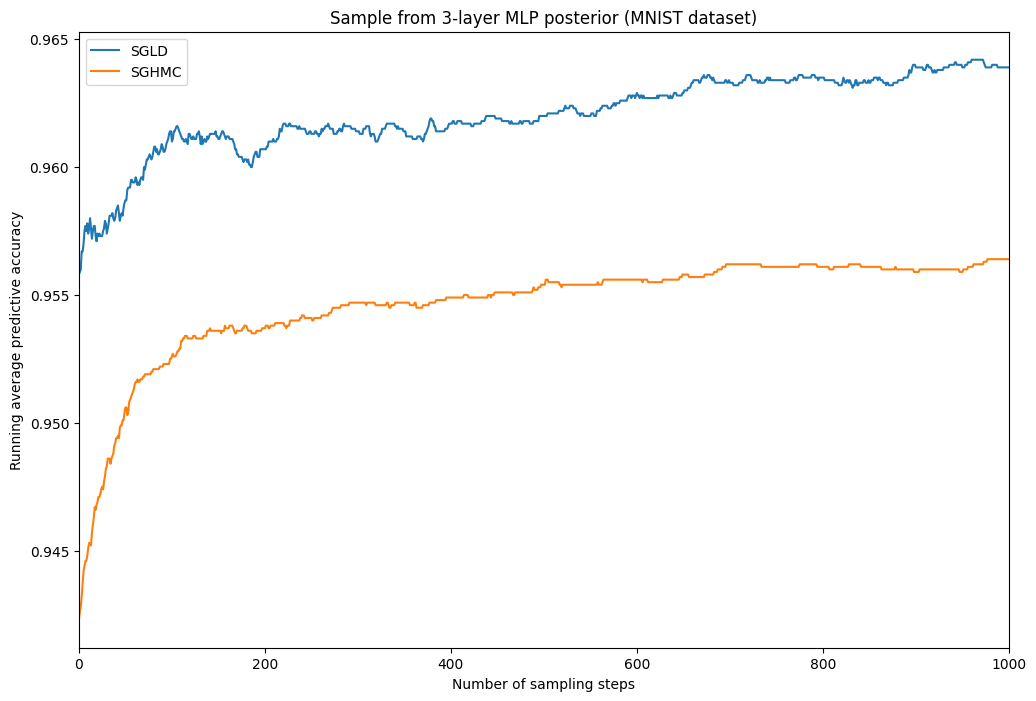

In [14]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(range(num_samples), sgld_accuracies, label="SGLD")
ax.plot(range(num_samples), sghmc_accuracies, label="SGHMC")
ax.set_xlabel("Number of sampling steps")
ax.set_ylabel("Running average predictive accuracy")
ax.set_xlim([0, num_samples])
plt.title("Sample from 3-layer MLP posterior (MNIST dataset)")
plt.legend()
plt.plot();

SGHMC gives a slightly better accuracy than SGLD. However, plotting this in terms of the number of steps is slightly misleading: SGHMC evaluates the gradient 10 times for each step while SGLD only once.

## Exploring uncertainty

Let us now use the average posterior predictive probabilities to see whether the model is overconfident. Here we will say that the model is unsure of its prediction for a given image if the digit that is most often predicted for this image is predicted less tham 95% of the time.

We will use SGHMC's prediction in the following.

In [15]:
predict_probs = jnp.exp(sghmc_logpredict) / num_samples
max_predict_prob = jnp.max(predict_probs, axis=1)
predicted = jnp.argmax(predict_probs, axis=1)

certain_mask = max_predict_prob > 0.95
print(f"Our model is certain of its classification for {np.sum(certain_mask) / y_test.shape[0] * 100:.1f}% of the test set examples." )

Our model is certain of its classification for 92.7% of the test set examples.


Let's plot a few examples where the model was very uncertain:

/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3493: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


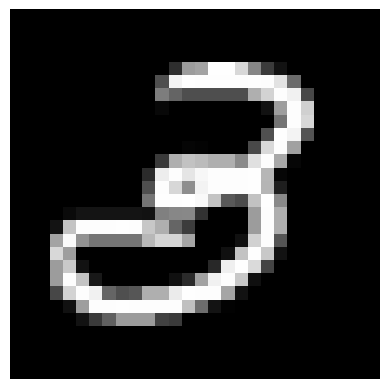

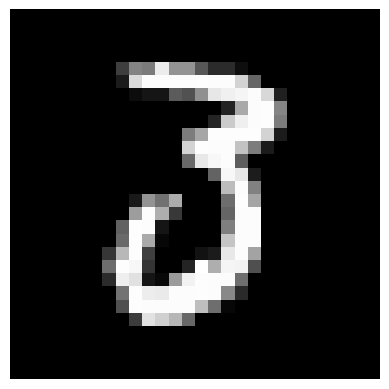

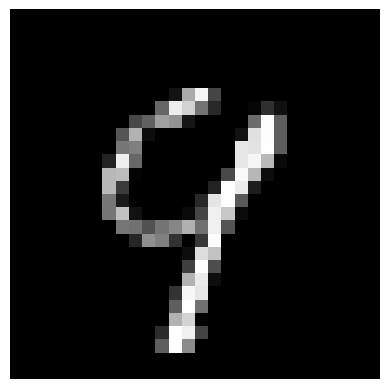

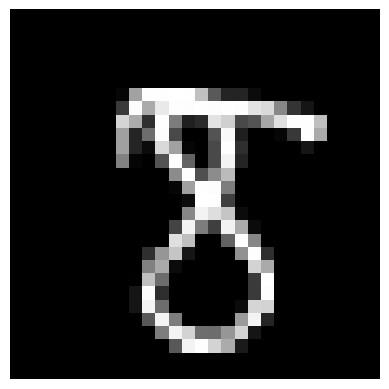

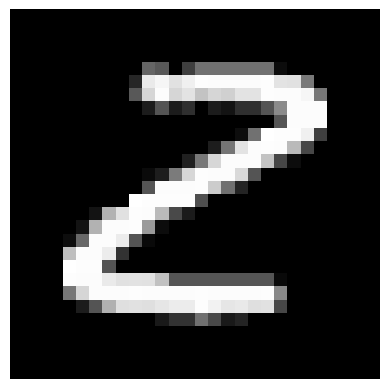

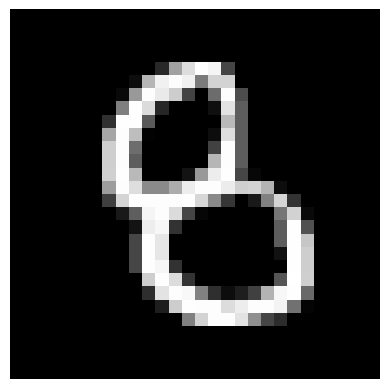

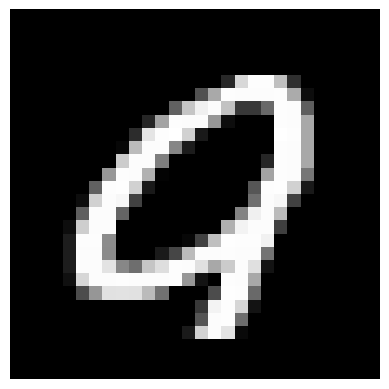

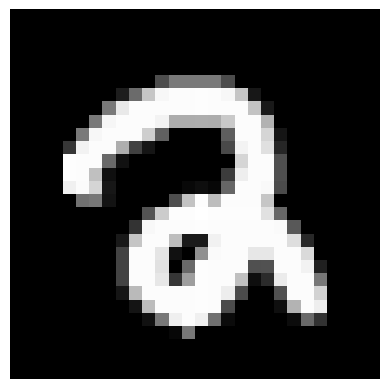

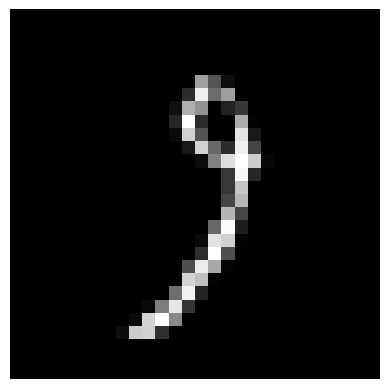

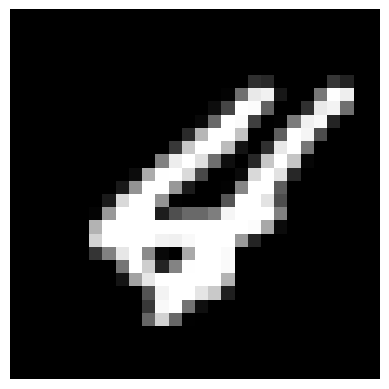

In [16]:
most_uncertain_idx = np.argsort(max_predict_prob)

for i in range(10):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(X_test[most_uncertain_idx[i]].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.show()

Are there digits that our model is more uncertain about? We plot the histogram of the number of times the model was unsure about each digit:

Text(0, 0.5, '# uncertain predictions')

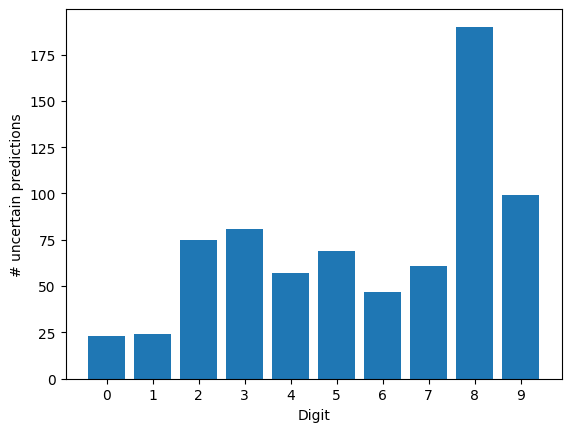

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

uncertain_mask = max_predict_prob < 0.95

ax.bar(np.arange(10), np.bincount(np.argmax(y_test[uncertain_mask], axis=1)))
ax.set_xticks(range(0,10))
ax.set_xlabel("Digit")
ax.set_ylabel("# uncertain predictions")

Perhaps unsurprisingly, the digit 8 is overrepresented in the set of examples $i$ for which $\max_d P(y_i=d|x_i) < 0.95$. As a purely academic exercise and sanity test of sort, let us now re-compute the point-wise accuracy ignoring the digits for which the model is uncertain, varying the threshold above which we consider the model to be certain:

In [18]:
def compute_accuracy(probs, y):
    predicted = jnp.argmax(probs, axis=1)
    target = jnp.argmax(y, axis=1)
    accuracy= jnp.mean(predicted==target)
    return accuracy

In [19]:
thresholds = np.linspace(0.1, 1., 90)

accuracies = []
dropped_ratio = []
for t in thresholds:
    certain_mask = max_predict_prob >= t
    dropped_ratio.append(100*(1 - np.sum(certain_mask) / np.shape(certain_mask)[0]))
    accuracies.append(compute_accuracy(predict_probs[certain_mask], y_test[certain_mask]))

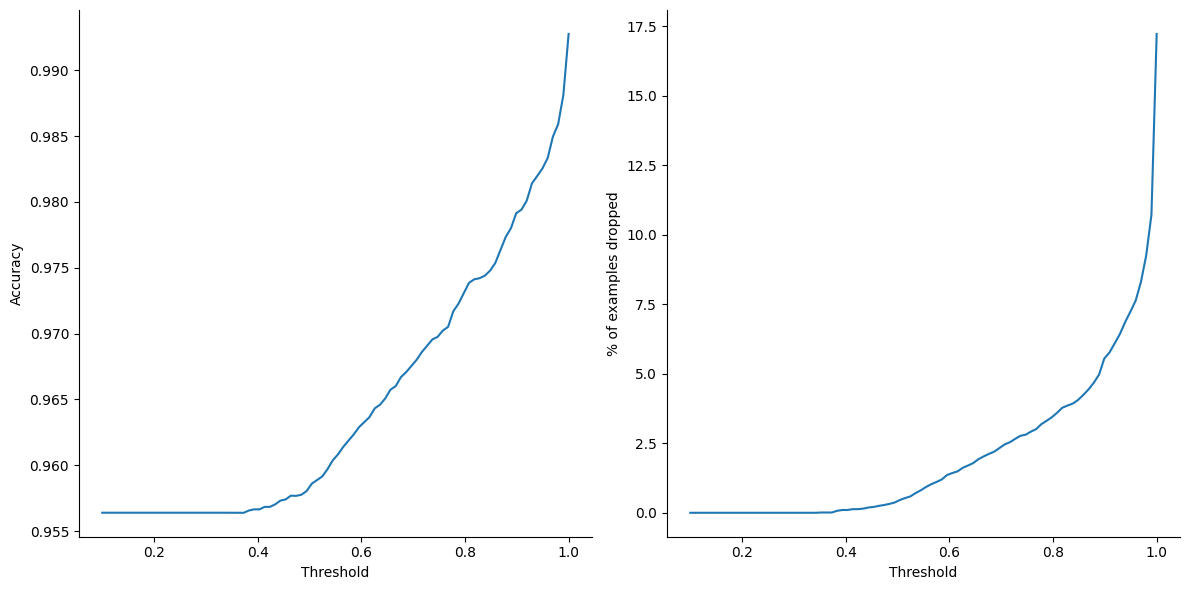

In [20]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.plot(thresholds, accuracies)
ax.set(xlabel="Threshold", ylabel="Accuracy")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(122)
ax.plot(thresholds, dropped_ratio)
ax.set(xlabel="Threshold", ylabel="% of examples dropped")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

Not bad at all, by dropping less than 2% of the samples we reach .99 accuracy, not too bad for such a simple model!

Such a simple rejection criterion may not be realistic in practice. But what Bayesian methods allow you to do is to design a *loss function* that describe the cost of each mistake (say choosing "1" when the digit was in fact "9"), and integrating this function over your posterior allows you to make principled decisions about which digit to predict for each example.